# Transition interval between two Rydberg states

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from starkhelium import *
from scipy.optimize import curve_fit

## Field-free transition

In [2]:
# quantum numbers
S = 1
n0, l0, j0 = 55, 0, 1
n1, l1, j1 = 56, 0, 1
# quantum defects
neff_01 =  np.array([n0, n1]) - get_qd(S, [n0, n1], [l0, l1], [j0, j1])
# field-free energies
en = En_0(neff_01)
# transition (atomic units)
tran = en[1] - en[0]
# frequency (if result is nan, check that j0 and j1 make sense)
print("The field-free transition frequency is %.4f GHz"%(1e-9 * tran * En_h / h))

The field-free transition frequency is 39.1130 GHz


## Stark effect

In [3]:
# quantum numbers for Stark matrix
nmin = 50
nmax = 60
m = 0
n_vals, L_vals = get_nl_vals(nmin, nmax, m)
J_vals = get_J_vals(S, L_vals, 1)
# quantum defects
neff = n_vals - get_qd(S, n_vals, L_vals, J_vals)
# field-free Hamiltonian
H_0 = np.diag(En_0(neff))
# find the off-diagonal terms of the Stark interaction matrix
mat_S = stark_matrix(neff, L_vals, m)

calculate Stark terms: 100%|████████████████████████████████████████████████████████| 605/605 [00:02<00:00, 230.20it/s]


In [4]:
# specify the electric field
field = np.linspace(0, 0.2, 1001) # V /cm
field_au = field * 100 * e * a_0 / En_h
# diagonalise
map1 = stark_map(H_0, mat_S, field_au)

diagonalise Hamiltonian: 100%|█████████████████████████████████████████████████████| 1001/1001 [00:49<00:00, 20.24it/s]


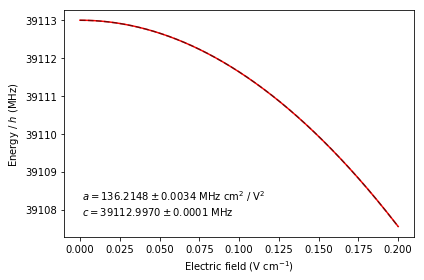

In [5]:
# fit function
def quad(x, a, c):
    return -a * x**2.0 + c

# transition states (assuming states do not cross)
idx0 = np.intersect1d(np.where(n_vals == n0), np.where(L_vals == l0))[0]
idx1 = np.intersect1d(np.where(n_vals == n1), np.where(L_vals == l1))[0]

# plot Stark shift
fig, ax = plt.subplots(figsize=(6, 4))

xvals = field
yvals = 1e-6*(map1[:, idx1] - map1[:, idx0]) * En_h /h
ax.plot(xvals, yvals, c='r', ls='-')

# fit
p0 = [-4.0e2, np.max(yvals)]
popt, pcov = curve_fit(quad, xvals, yvals, p0=p0)
perr = pcov.diagonal()**0.5 
fit_info = '$a = %.4f \pm %.4f $ MHz cm$^2$ / V$^2$ \n$c = %.4f \pm %.4f $ MHz' % \
           (popt[0], perr[0], popt[1], perr[1])
yfit = quad(xvals, *popt)
ax.plot(xvals, yfit, c='k', alpha=0.5, ls='--')

# format
ax.text(0.05, 0.1, fit_info, transform=ax.transAxes)
ax.set_xlabel('Electric field (V cm$^{-1}$)')
ax.set_ylabel('Energy / $h$ (MHz)')
plt.tight_layout()
# output
fileout = os.path.join("..", "images", "55s-56s_stark_shift.png")
plt.savefig(fileout)
plt.show()